In [4]:
from __future__ import unicode_literals, print_function, division
from io import open 
import glob 
import unicodedata 
import string
import torch
import torch.nn as nn
import random


def findFiles(path): 
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

category_lines = {} 
all_categories = [] 

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [line for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]    
    all_categories.append(category)
    lines = readLines(filename) 
    category_lines[category] = lines 

n_categories = len(all_categories)

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']


In [2]:
def letterToIndex(letter):
    return all_letters.find(letter)
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [159]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) 

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) 
        hidden = self.i2h(combined)
        output = self.i2o(combined) 
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories) 

In [ ]:
def categoryFromOutput(output): 
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item() 
    return all_categories[category_i], category_i

In [5]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)] 

def randomTrainingExample():
    category = randomChoice(all_categories) 
    line = randomChoice(category_lines[category]) 
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line) 
    return category, line, category_tensor, line_tensor

for i in range(5):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Korean / line = Yi
category = Dutch / line = Klerks
category = Portuguese / line = Almeida
category = Greek / line = Bertsimas
category = Portuguese / line = Vargas


In [162]:
criterion = nn.NLLLoss() 

In [163]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden() 

    rnn.zero_grad() 

    for i in range(line_tensor.size()[0]): 
        output, hidden = rnn(line_tensor[i], hidden) #rnn(input[0], hidden) 

    loss = criterion(output, category_tensor) 
    loss.backward() 

    for p in rnn.parameters(): 
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() 

In [176]:
import time
import math

n_iters = 100000
print_every = 5000 
plot_every = 1000 

current_loss = 0 
all_losses = [] 

def timeSince(since):
    now = time.time()
    s = now - since 
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1): 
    category, line, category_tensor, line_tensor = randomTrainingExample() 
    output, loss = train(category_tensor, line_tensor) 
    current_loss += loss 

    if iter % print_every == 0: 
        guess, guess_i = categoryFromOutput(output) 
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0: 
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 1.4092 Rao / Vietnamese ✗ (Chinese)
10000 10% (0m 11s) 1.5664 Teunissen / Dutch ✓
15000 15% (0m 17s) 1.8509 Estévez / Polish ✗ (Spanish)
20000 20% (0m 22s) 2.3377 Mcphee / Scottish ✗ (English)
25000 25% (0m 27s) 0.5078 You / Korean ✓
30000 30% (0m 33s) 0.8315 Chun / Korean ✓
35000 35% (0m 39s) 1.0974 Acconcio / Italian ✓
40000 40% (0m 44s) 2.5380 Winther / Arabic ✗ (German)
45000 45% (0m 49s) 0.4715 O'Byrne / Irish ✓
50000 50% (0m 56s) 1.6195 Movchun / Irish ✗ (Russian)
55000 55% (1m 1s) 1.1086 Snyder / Dutch ✓
60000 60% (1m 6s) 1.3461 Royer / French ✓
65000 65% (1m 11s) 2.6547 Martel / Portuguese ✗ (French)
70000 70% (1m 16s) 1.6927 Cann / Chinese ✗ (Dutch)
75000 75% (1m 21s) 1.0708 Krupala / Czech ✓
80000 80% (1m 27s) 2.6342 Sloan / Scottish ✗ (English)
85000 85% (1m 31s) 0.1599 Hyun  / Korean ✓
90000 90% (1m 37s) 1.3611 Casales / Portuguese ✗ (Spanish)
95000 95% (1m 42s) 3.0162 Rios / Portuguese ✗ (Spanish)
100000 100% (1m 48s) 1.5849 Ter Avest / French ✗ (Dutch)


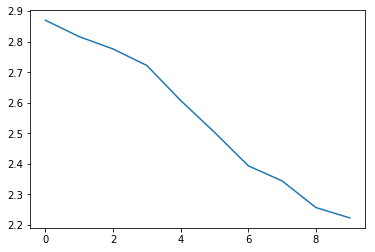

In [175]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000


def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [203]:

def predict(input_line, n_predictions=5): 
    print('\n> %s' % input_line) 
    with torch.no_grad(): 
        output = evaluate(lineToTensor(input_line))

        topv, topi = output.topk(n_predictions, 1) 
        predictions = []

        for i in range(n_predictions): 
            value = topv[0][i].item() 
            category_index = topi[0][i].item() 
            print(all_categories[category_index]) 
            #print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Bill')
predict('Jerry')


> Bill
Irish
English
Scottish
German
Czech

> Jerry
Scottish
English
French
Czech
Dutch
